In [ ]:
# Start writing code here...

In [1]:
import sys
sys.path.append('..')

import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


from lib.viz import draw_missing_data_chart, draw_corr_heatmap, draw_components_variance_chart, biplot, draw_feature_importance, draw_histogram

from lib.transform_impute import *
from lib.split_data import group_split, train_test_split_single_level_index
from lib.create_pipeline import create_transformation_pipeline
from lib.read_data import read_feature_files, read_and_join_output_file

from lib.supervised_tuning import predict_score_base_regressors
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor

%matplotlib inline


/shared-libs/python3.9/py/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
all_features_target_df = read_and_join_output_file(start_year=2014, end_year=2021)
print(all_features_target_df.shape)
#There are 81 columns and the index is a combination of township range and year that is separate from these columns

(3824, 81)


### Study the target variables

##### Shortage

In [3]:
#To  enable us to view the township and range in the hover tooltip, make a subset of the dataframe

shortage_subset_df = all_features_target_df[['SHORTAGE_COUNT', 'GSE_GWE']].copy()
shortage_subset_df = shortage_subset_df.reset_index()

 

**Observed** 

T21SR28E reports most shortage during the severe drought years of 2014 and 2015 followed by T21SR27E.



In [4]:
_deepnote_run_altair(shortage_subset_df, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"color":{"field":"TOWNSHIP_RANGE","scale":{"type":"linear","zero":false},"sort":null,"type":"nominal"},"x":{"field":"YEAR","scale":{"type":"linear","zero":false},"sort":null,"type":"nominal"},"y":{"field":"SHORTAGE_COUNT","scale":{"type":"linear","zero":true},"sort":null,"type":"quantitative"}},"height":220,"mark":{"tooltip":{"content":"data"},"type":"bar"}}""")

alt.Chart(...)

##### Groundwater levels

- Observed below: a dip in the groundwater levels from 2014 through 2016, the drought years, 
- then an increase until 2020 and followed by a drop in 2021, another sever drought year.

In [5]:
_deepnote_run_altair(shortage_subset_df, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"point","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"YEAR","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"GSE_GWE","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"color":{"field":"TOWNSHIP_RANGE","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

### Set random state seed for consistency and reproducibility

- Use this random seed for preprocessinf 

In [6]:
RANDOM_SEED = 42

### Split the data into train and test 

-  So that we only transform the test data and there is no data leakage


We will use the years 2014-2020 as the train set and the year 2021 as the test set. There are features in the year 2021 that are missing and so we will combine the two sets to have available to us **past** years data to forward fill the features in the impute test set. The key is that we are not in the learning task here, and this holdout set is the future set, so we are not leaking information back into the past.

In [7]:
feature_columns = [col for col in all_features_target_df.columns if col not in ['TOWNSHIP_RANGE', 'YEAR', "GSE_GWE", "SHORTAGE_COUNT"]]
year_list = list(all_features_target_df.index.get_level_values('YEAR').unique())
train_year_list = year_list[0:len(year_list) - 1]
test_year_list = year_list[-1]
X_train, y_train = all_features_target_df.loc[(slice(None),train_year_list),feature_columns].copy(),all_features_target_df.loc[(slice(None),train_year_list),'GSE_GWE']
X_test, y_test = all_features_target_df.loc[(slice(None),test_year_list),feature_columns].copy(), all_features_target_df.loc[(slice(None),test_year_list),'GSE_GWE']

full_X  = X_train.append(X_test)

### Preprocessing Data


In [8]:
draw_missing_data_chart(X_train)

alt.LayerChart(...)

##### Decision on imputation to be applied to missing variables
 
We have several variables that are null as seen in the chart above.
----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**Vegetation dataset**

**Cause** We do not have data for the above vegetation after 2014 for any of the TownshipRanges. That is it is absent for the years [2015, 2016, 2017, 2018, 2019, 2020, 2021]. 

**Imputation**
We will be making an assumption that the vegetation landscape of a TownshipRange does not radically differ from year to year. The vegetation values will carry over from 2014 for these vegetation types for each of the township ranges.  The imputation is carried out by finding the mean of the data for all Townships. This will be the only available data in the year 2016. This is then filled into the rest of the years for each TownshipRange using a merge.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________


**Crops dataset** 

- For all Crops features

**Cause** We only data for 3 years over the analysis survey, 2014, 2016, 2018

**Imputation**
 We assume little year-to-year variation in crop farming and extended the data for the missing years (2015, 2017, 2019) with the data from the previous years (i.e. we assume that 2015 crops = 2014 crops). We understand that farming practices like crop rotation would challenge these assumptions. The imputation is carried out by sorting the dataframe by year and then township and then forward filling the data over to the years following.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**Soils dataset**

**Cause**  We have data for soils for 2016 and not for other years. 

**Imputation**
We will be making an assumption that the basic nature of the soil of a TownshipRange does not radically differ from year to year. As we do not expect the soil type to change from year, the 2016 soil data are used for all the other years. The imputation is carried out by finding the mean of the data for all Townships. This will be the only available data in the year 2016. This is then filled into the rest of the years for each TownshipRange using a merge.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________


**WELL COMPLETION**

**Cause** Absence of well completion reports filed in township range in certain, or all years causes values to be null

**Imputation**

We impute the GROUNDSURFACEELEVATION_AVG for a TownshipRange as the mean of the values over all years for that TownshipRange. This value that is stored in the data is the average of the elevation of the ground where wells were constructed in that TownshipRange and hence elevation was known. 

But this does not cover all the NaNs since 76 TRs do not have any value at all and  they should be filled with the average elevation of the entire area?

For the other variables since they are the **average** of the well yield, static water level, top of perforated interval, bottom of perforated interval and total completed depth of the wells constructed in each TownshipRange and so if there are **no wells newly constructed**, in a township range in a certain year, **this value will be set to 0** as these variables are well specific measurements. 


----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**RESERVOIR**

**Cause** Reservoir data is available from the California reporting stations from 2018, we are missing the data from 2014 through 2017.  

**Imputation**
Since in these years, California was stricken with drought, we will impute the values to be the **minimum** of the PCT_OF_CAPACITY for that TownshipRange.

----------------------------------------------------------------------------------------------------
____________________________________________________________________________________________________

**POPULATION**

**Cause** Population density is missing for the final year of 2021 for all townships.

**Imputation**
We will be using the previous years(2020's) trend over the year 2019 and add to the previous years (2020) value for each TownshipRanges  for the missing values in year 2021.






____________________________________________________________________________________________________
____________________________________________________________________________________________________


**NOTE**:
[Reference article](https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a)
>Pipeline steps are executed serially, where the output from the first step is passed to the second step, and so on.
> ColumnTransformers are different in that each step is executed separately, and the transformed features are concatenated at the end.
>By default, any columns you pass into the ColumnTransformer that aren’t specified to be transformed will be dropped (remainder='drop'). If you have columns that you want to include but do not need to be transformed, specify remainder='passthrough'.


#### Transformation

- FunctionTransformers : enable working with a set of columns and applying transormation particular to them
- Extending the base estimator class : extends the fit and transform functionality of the BaseEstimator and transformer class
- We have a choice between Standard and Min-Max scaler. Some of the algorith require data to be centered and normalized - PCA and UMAP for instance. I have chosen StandardScaler below for that reason. 

### Impute missing Data and Scale numeric data

- Standard Scaling : Standardize features by removing the mean and scaling to unit variance.
The standard score of a sample x is calculated as:
z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

- SVM and StandardScaling
Many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

- MinMaxScaling 
Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

The transformation is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min

In [9]:
#We can try differerent scores with MinMaxScaler and StandardScaler
# I have stored the output of imputing and scaling using StandardScaler and run SVM
#Now trying out MinMaxScaler
impute_pipe = create_transformation_pipeline(X_train, scaler = MinMaxScaler())
X_train_impute = impute_pipe.fit_transform(X_train)

In [10]:
set_config(display="diagram")
display(impute_pipe)

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('wcr',
                                 Pipeline(steps=[('imputer',
                                                  PandasSimpleImputer(fill_value=0,
                                                                      strategy='constant')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['TOTALDRILLDEPTH_AVG', 'WELLYIELD_AVG',
                                  'STATICWATERLEVEL_AVG',
                                  'TOPOFPERFORATEDINTERVAL_AVG',
                                  'BOTTOMOFPERFORATEDINTERVAL_AVG',
                                  'TOTALCOMPLETEDDEPTH_AVG']),
                                ('veg',
                                 FunctionTransfor...
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(aggregation_func='min',
                                                               group_by_cols=['TOWNSHIP_RANGE'],
                                                               impute_for_col='PCT_OF_CAPACITY')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['PCT_OF_CAPACITY']),
                                ('gse',
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(group_by_cols=['TOWNSHIP_RANGE'],
                                                               impute_for_col='GROUNDSURFACEELEVATION_AVG')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['GROUNDSURFACEELEVATION_AVG'])])

### Convert the numpy array to dataframe to view the columns imputation results

In [11]:
X_train_impute_df = convert_back_df(
    X_train_impute,
    impute_pipe,
    X_train,
)
draw_missing_data_chart(X_train_impute_df)
X_train_impute_df.to_pickle('X_train_impute_minmax_df.pkl')

### Make sure the test set is now withdrawn from the full set

In [12]:
X_full_impute = impute_pipe.transform(full_X)
full_impute_df = convert_back_df(
    X_full_impute,
    impute_pipe,
    full_X
)
#Use the test years
X_test_impute_df = full_impute_df.loc[(slice(None),test_year_list),:].copy()

X_test_impute_df.to_pickle('X_test_impute_minmax_df.pkl')

X_test_impute = X_test_impute_df.values 
draw_missing_data_chart(X_test_impute_df)

alt.LayerChart(...)

### Find feature correlation 

In [13]:
draw_corr_heatmap(X_train_impute_df.reset_index(), ['TOWNSHIP_RANGE', 'YEAR'])

alt.Chart(...)

#### Co-related features observations

Well construction specific correlations that can be considered as expected since each value describes the well's dimensions and capacity

- We are considereing features with absolute value of 0.7 as being highly correlated
- Scrolling to the right of the heatmap, we see TOPOFPERFORATEDINTERVAL and BOTTOMOFPERFORATEDINTERVAL highly correlated
- BOTTOMOFPERFORATEDINTERVAL and TOPOFPERFORATEDINTERVAL are heavily correlated with TOTALCOMPLETEDDEPTH
- TOTALCOMPLETEDDEPTH is correlated with STATICWATERLEVEL

**Well Count**

- This feature was further categorized as Domestic, Agriculture and Public and hence is highly correlated to the categories (WELL_COUNT --> (WELL_COUNT_DOMESTIC, WELL_COUNT_AGRICULTURE))

**Crops**

We observe some few other correlations between
* some type of crops (e.g. 0.57 between `CROP_D16` *plums, prunes or apricots* and `CROP_D5` which is *peaches/nectarines*
* or between some crops and soils (e.g. 0.61 between `CROP_T31` *potatoes and sweet potatoes* and `SOIL_ENTISOLS_A` soil of hydrographic group *A* corresponding to coarse texture soils with high saturated hydraulic conductivity. This correlation also makes sense since potatoes tend to not grow well in soils retaining too much water.

**Vegetation**

We also see some level of correlation between the different type of forest vegetation. For example `VEGETATION_CANYON_LIVE_OAK`, `VEGETATION_HARD` and `VEGETATION_KNOBCONE_PINE` show correlation values between 0.46 and 0.6. This might be explained by the fact that some type of vegetation tend to live together.




### Dimensionality reduction for multiple vegetation, crops and soil

##### TBD

- PCA Heatmap

- Scree Plot explained_variance_ratios!!

- KMeans clustering, incorporating the clusters into the data and then running regression

- RandomForestRegressor and Feature Importance


In [14]:
# How many features will it take to explain 95% of the variance
pca = PCA()
X_pca = pca.fit_transform(X_train_impute_df)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_70 = len(total_explained_variance[total_explained_variance >= .70])
n_to_reach_70 = X_train_impute_df.shape[1] - n_over_70 + 1
print(f"Number features: {n_to_reach_70}\tTotal Variance Explained: {total_explained_variance[n_to_reach_70-1]}")

Number features: 12	Total Variance Explained: 0.7011788780039228


In [ ]:
draw_components_variance_chart(pca)

alt.Chart(...)

In [15]:
print("Cumulative Variances (Percentage):")
print(pca.explained_variance_ratio_.cumsum() * 100)
print()

Cumulative Variances (Percentage):
[ 13.24172437  23.65249002  32.06438136  38.92878661  44.52809996
  49.7148824   53.7779336   57.60765676  61.12619906  64.36740898
  67.29249295  70.1178878   72.56710803  74.88056489  76.9058181
  78.88485249  80.68525123  82.4049158   84.02935421  85.46122335
  86.87667855  88.05042225  89.20161188  90.28110398  91.31514026
  92.18469573  92.88100769  93.45000401  93.97916704  94.4863768
  94.95611158  95.41245464  95.84530726  96.25448052  96.62657582
  96.95646328  97.27477959  97.58048414  97.81541399  98.0278519
  98.23112823  98.41154931  98.56237876  98.70898871  98.85075965
  98.98417779  99.10304778  99.21550716  99.31563904  99.39655276
  99.47615848  99.54667456  99.60947071  99.66078706  99.7086617
  99.75262576  99.79152702  99.82605394  99.85795298  99.88145183
  99.89976051  99.91652943  99.93232052  99.94637237  99.95798013
  99.96861424  99.97445074  99.97966968  99.98439646  99.98734758
  99.99014782  99.99285907  99.99487755  99.9

### Use number of components that explain 70% of the variance

In [16]:
pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train_impute_df)

In [17]:
pca_components = abs(pca.components_)
print('Top 4 most important features in each component')
print('===============================================')
for row in range(pca_components.shape[0]):
    # get the indices of the top 4 values in each row
    temp = np.argpartition(-(pca_components[row]), 4)
    
    # sort the indices in descending order
    indices = temp[np.argsort((-pca_components[row])[temp])][:4]
    
    # print the top 4 feature names
    print(f'Component {row}: {X_train_impute_df.columns[indices].to_list()}')

Top 4 most important features in each component
Component 0: ['SOIL_ENTISOLS_B', 'VEGETATION_NON-NATIVE_HARDWOOD_FOREST', 'PCT_OF_CAPACITY', 'TOTALCOMPLETEDDEPTH_AVG']
Component 1: ['PCT_OF_CAPACITY', 'SOIL_ARIDISOLS_D', 'VEGETATION_NON-NATIVE_HARDWOOD_FOREST', 'SOIL_ARIDISOLS_B']
Component 2: ['SOIL_ALFISOLS_D', 'SOIL_ENTISOLS_B', 'TOPOFPERFORATEDINTERVAL_AVG', 'TOTALCOMPLETEDDEPTH_AVG']
Component 3: ['CROP_D12', 'PCT_OF_CAPACITY', 'TOTALCOMPLETEDDEPTH_AVG', 'TOPOFPERFORATEDINTERVAL_AVG']
Component 4: ['SOIL_VERTISOLS_D', 'SOIL_ALFISOLS_D', 'SOIL_ARIDISOLS_B', 'POPULATION_DENSITY']
Component 5: ['CROP_D12', 'VEGETATION_NON-NATIVE_HARDWOOD_FOREST', 'SOIL_ALFISOLS_C', 'SOIL_MOLLISOLS_B']
Component 6: ['SOIL_ARIDISOLS_D', 'SOIL_ARIDISOLS_B', 'SOIL_VERTISOLS_D', 'SOIL_MOLLISOLS_B']
Component 7: ['POPULATION_DENSITY', 'SOIL_ALFISOLS_C', 'SOIL_MOLLISOLS_B', 'SOIL_ARIDISOLS_B']
Component 8: ['SOIL_MOLLISOLS_B', 'SOIL_VERTISOLS_D', 'SOIL_INCEPTISOLS_B', 'SOIL_ARIDISOLS_D']
Component 9: ['VEGE

#### Biplot to visualize PCA orientations and scores 

<module 'matplotlib.pyplot' from '/shared-libs/python3.9/py/lib/python3.9/site-packages/matplotlib/pyplot.py'>

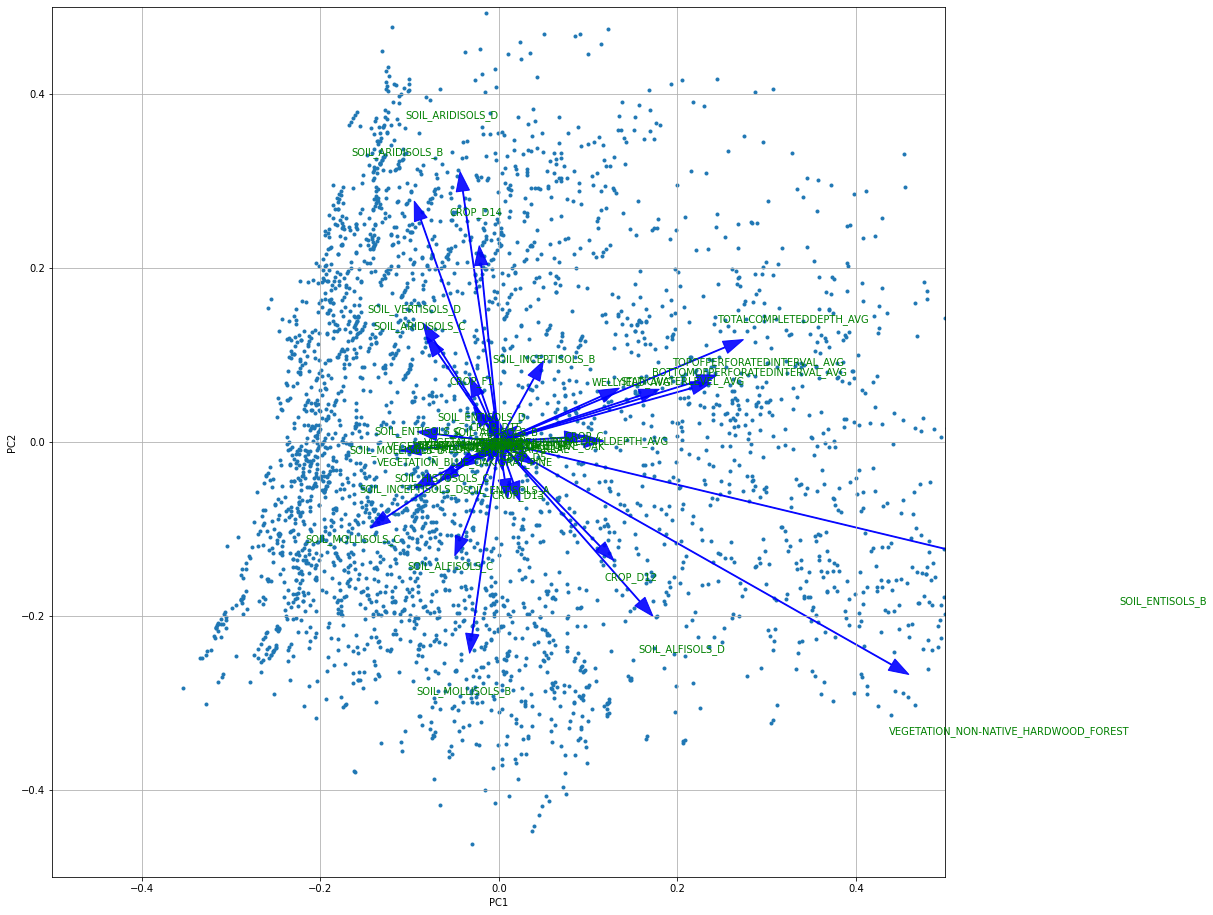

In [18]:
feature_subset_count = 45
feature_names=list(X_train_impute_df.columns)
feature_subset = slice(0, feature_subset_count, 1)

biplot(X_train_pca, np.transpose(pca.components_[0:2, feature_subset]), 
       feature_subset_count, 1, 2, labels=feature_names[feature_subset])

   

In the data transformed by MinMaxScaler, when we apply dimensionality reduction and plot the data as projected in the new axis with the two primary axis, we see that all the well related data has the same direction, some of the soils that are particularly suited for agriculture align with the crop typically grown in San Joaquin Valley.

Note above CROP_D12 (Almonds) aligned closely Alfisol_D which as per [USDA soil taxonomy](https://dbpedia.org/page/Alfisol):
Because of their productivity and abundance, the Alfisols represent one of the more important soil orders for food and fiber production. They are widely used both in agriculture and forestry, 

In [19]:
X_test_pca= pca.transform(X_test_impute)

In [20]:

file_exists = os.path.exists('X_pca_minmax.pickle')

if not file_exists:
    train_test_dict = {"X_train_pca": X_train_pca, 
                      "X_test_pca": X_test_pca,
                      "y_train": y_train,
                      "y_test": y_test,
                }

    with open('X_pca_minmax.pickle', 'wb') as file:
        pickle.dump(train_test_dict, file)

###  Feature Importance

In [ ]:
col_list = [ col for col in X_train_impute_df if "TOWNSHIP_RANGE" not in col  and 'YEAR' not in col]
rfreg = RandomForestRegressor().fit(X_train_impute_df[col_list], y_train)
draw_feature_importance(col_list, rfreg.feature_importances_)

alt.Chart(...)

In [ ]:
#Store the train and test sets in pickle files

file_exists = os.path.exists('train_test_dict_minmax.pickle')

if not file_exists:
    train_test_dict = {"X_train_impute": X_train_impute, 
                      "X_test_impute": X_test_impute,
                      "y_train": y_train,
                      "y_test": y_test,
                }

    with open('train_test_dict_minmax.pickle', 'wb') as file:
        pickle.dump(train_test_dict, file)




In [ ]:
X_train_impute_df.to_pickle("X_train_impute_minmax_df.pkl")
X_test_impute_df.to_pickle("X_test_impute_minmax_df.pkl")


###  Analyze Shapley Feature Importance

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>